In [8]:
df.columns

Index(['issue', 'datetime_3h', 'channel', 'viewCount', 'likeCount',
       'comment_cnt', 'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h',
       'match_sum', 'Entity', 'Event', 'Cause', 'Impact', 'Reaction', 'Lflag',
       'abs_sent_gap', 'D', 'count', 'Lnorm', 'W', 'C_cur', 'W_norm', 'FlagP',
       'c_0_3', 'c_3_6', 'c_6_9', 'er_0_3', 'er_3_6', 'er_6_9', 'R', 'mu_R',
       'std_R', 'P_z', 'P'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import os

# ========================================================
# 1) 댓글 기반 P지수 계산 함수
# ========================================================
def calc_P(df, group_col="channel", gamma=1.0):
    df = df.copy()

    # 유튜브만 P 계산
    df["FlagP"] = np.where(df["channel"] == "유튜브", 1, 0)

    # 시간대별 댓글 증가량
    df["c_0_3"] = df["aligned_cnt_3h"]
    df["c_3_6"] = df["aligned_cnt_6h"]
    df["c_6_9"] = df["aligned_cnt_9h"]

    # 반응률: 댓글증가량 / (조회수 + 1)
    df["er_0_3"] = df["c_0_3"] / (df["viewCount"] + 1)
    df["er_3_6"] = df["c_3_6"] / (df["viewCount"] + 1)
    df["er_6_9"] = df["c_6_9"] / (df["viewCount"] + 1)

    # 가중합
    w1, w2, w3 = 0.6, 0.3, 0.1
    df["R"] = (
        w1 * df["er_0_3"] +
        w2 * df["er_3_6"] +
        w3 * df["er_6_9"]
    )

    # 그룹별 평균·표준편차
    df["mu_R"] = df.groupby(group_col)["R"].transform("mean")
    df["std_R"] = df.groupby(group_col)["R"].transform("std").replace(0, 1e-9)

    # Z-score
    df["P_z"] = (df["R"] - df["mu_R"]) / df["std_R"]

    # 시그모이드로 0~1 스케일
    df["P"] = 1 / (1 + np.exp(-gamma * df["P_z"]))

    # 유튜브 외 채널 P 제거
    df.loc[df["FlagP"] == 0, "P"] = np.nan

    return df


# ========================================================
# 2) 파일 목록 & 회사명
# ========================================================
file_paths = [
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\GS_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\SKT_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\롯데_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\KT_W.xlsx"
]

company_names = ["GS", "SKT", "롯데", "KT"]


# ========================================================
# 3) 순회하며 P 계산 → 미리보기 출력 → 저장
# ========================================================
output_dir = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\P_output"
os.makedirs(output_dir, exist_ok=True)

for file_path, company in zip(file_paths, company_names):

    print(f"\n============================")
    print(f"▶ [{company}] 파일 처리 중")
    print(f"============================")

    df = pd.read_excel(file_path)

    # P 계산
    df_p = calc_P(df)

    # ------- 🔍 저장 전 미리보기 출력 --------
    print(f"\n📌 [미리보기: {company}] (상위 10개 행)")
    print(
        df_p[
            [
                "channel",
                "viewCount",
                "aligned_cnt_3h","aligned_cnt_6h","aligned_cnt_9h",
                "er_0_3","er_3_6","er_6_9",
                "R","P_z","P","FlagP"
            ]
        ].head(10)
    )

    # ------- 📁 저장 --------
    save_path = os.path.join(output_dir, f"{company}_WP.xlsx")
    df_p.to_excel(save_path, index=False, engine="openpyxl")
    print(f"\n✔ 저장 완료: {save_path}")


print("\n================ 전체 P지수 계산 완료 ================")



▶ [GS] 파일 처리 중

📌 [미리보기: GS] (상위 10개 행)
  channel  viewCount  aligned_cnt_3h  aligned_cnt_6h  aligned_cnt_9h  er_0_3  \
0    blog          0               0               0               0     0.0   
1    blog          0               0               0               0     0.0   
2    blog          0               0               0               0     0.0   
3    blog          0               0               0               0     0.0   
4    blog          0               0               0               0     0.0   
5    blog          0               0               0               0     0.0   
6    blog          0               0               0               0     0.0   
7    blog          0               0               0               0     0.0   
8    blog          0               0               0               0     0.0   
9    blog          0               0               0               0     0.0   

   er_3_6  er_6_9    R  P_z   P  FlagP  
0     0.0     0.0  0.0  0.0 NaN      

In [3]:
import pandas as pd
import numpy as np
import os

# ========================================================
# 1) 댓글 기반 P지수 계산 함수 (issue와 channel 단위로 계산)
# ========================================================
def calc_P_for_issue(df_issue, gamma=1.0):
    df_issue = df_issue.copy()

    # 유튜브만 P 계산하도록 flag 생성
    df_issue["FlagP"] = np.where(df_issue["channel"] == "유튜브", 1, 0)

    # 시간대별 댓글 증가량
    df_issue["c_0_3"] = df_issue["aligned_cnt_3h"]
    df_issue["c_3_6"] = df_issue["aligned_cnt_6h"]
    df_issue["c_6_9"] = df_issue["aligned_cnt_9h"]

    # 반응률: 댓글증가량 / (조회수 + 1)
    df_issue["er_0_3"] = df_issue["c_0_3"] / (df_issue["viewCount"] + 1)
    df_issue["er_3_6"] = df_issue["c_3_6"] / (df_issue["viewCount"] + 1)
    df_issue["er_6_9"] = df_issue["c_6_9"] / (df_issue["viewCount"] + 1)

    # 가중합
    w1, w2, w3 = 0.6, 0.3, 0.1
    df_issue["R"] = (
        w1 * df_issue["er_0_3"] +
        w2 * df_issue["er_3_6"] +
        w3 * df_issue["er_6_9"]
    )

    # ---------------------------------------------
    # issue 단위에서 channel별 평균/표준편차
    # ---------------------------------------------
    df_issue["mu_R"] = df_issue.groupby("channel")["R"].transform("mean")
    df_issue["std_R"] = df_issue.groupby("channel")["R"].transform("std").replace(0, 1e-9)

    # Z-score
    df_issue["P_z"] = (df_issue["R"] - df_issue["mu_R"]) / df_issue["std_R"]

    # 시그모이드 스케일링
    df_issue["P"] = 1 / (1 + np.exp(-gamma * df_issue["P_z"]))

    # 유튜브 외 채널은 P = NaN
    df_issue.loc[df_issue["FlagP"] == 0, "P"] = np.nan

    return df_issue


# ========================================================
# 2) 전체 파일 로드
# ========================================================
input_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_with_Wnorm.xlsx"
df = pd.read_excel(input_path)

print("전체 df 로드 완료")

# 3) 모든 이슈에 대해 순차적으로 P 계산
# ========================================================
df_list = []

for issue_name in df["issue"].unique():
    print(f"\n▶ {issue_name} P 계산 중...")
    
    df_issue = df[df["issue"] == issue_name].copy()
    df_issue_p = calc_P_for_issue(df_issue, gamma=1.0)
    
    df_list.append(df_issue_p)

# issue 단위 계산한 것들을 다시 결합
df_final = pd.concat(df_list, ignore_index=True)

print("\n모든 이슈 P 계산 완료")


# ========================================================
# 4) 결과 저장
# ========================================================
output_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P.xlsx"
df_final.to_excel(output_path, index=False, engine="openpyxl")

print(f"\n✔ 전체 데이터 저장 완료: {output_path}")


전체 df 로드 완료

▶ GS P 계산 중...

▶ KT P 계산 중...

▶ SKT P 계산 중...

▶ 롯데 P 계산 중...

모든 이슈 P 계산 완료

✔ 전체 데이터 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P.xlsx


In [5]:
gs_wp_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P.xlsx"
df = pd.read_excel(gs_wp_path)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   issue           1355 non-null   object        
 1   datetime_3h     1355 non-null   datetime64[ns]
 2   channel         1355 non-null   object        
 3   viewCount       1355 non-null   int64         
 4   likeCount       1355 non-null   int64         
 5   comment_cnt     1355 non-null   int64         
 6   aligned_cnt_3h  1355 non-null   int64         
 7   aligned_cnt_6h  1355 non-null   int64         
 8   aligned_cnt_9h  1355 non-null   int64         
 9   match_sum       1355 non-null   int64         
 10  Entity          1355 non-null   int64         
 11  Event           1355 non-null   int64         
 12  Cause           1355 non-null   int64         
 13  Impact          1355 non-null   int64         
 14  Reaction        1355 non-null   int64         
 15  Lfla


▶ [GS] 4분면 분석 시작

=== [GS] 유튜브 4분면 분포 (전체 14개) ===
            사분면  개수  비율(%)
0  Q4 (확산↓ 반응↑)   7   50.0
1  Q1 (확산↑ 반응↑)   7   50.0 



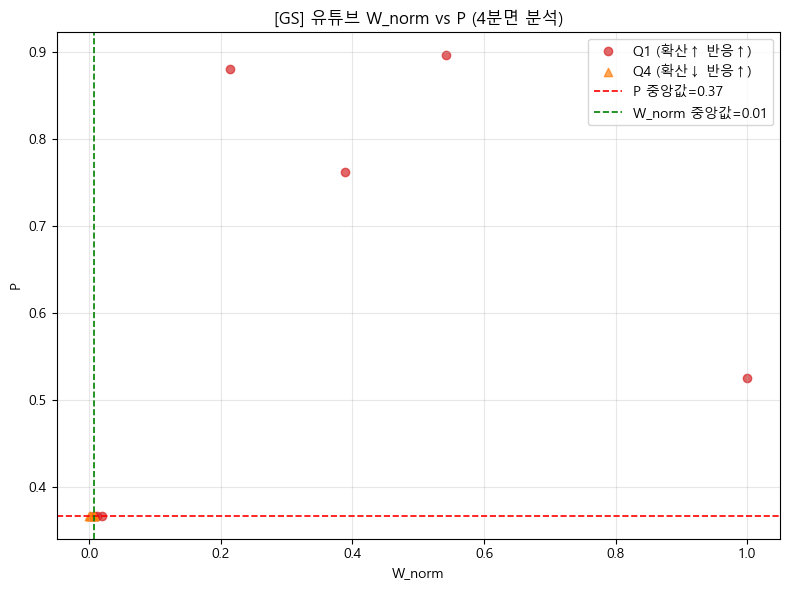


▶ [KT] 4분면 분석 시작

=== [KT] 유튜브 4분면 분포 (전체 80개) ===
            사분면  개수  비율(%)
0  Q4 (확산↓ 반응↑)  40   50.0
1  Q1 (확산↑ 반응↑)  40   50.0 



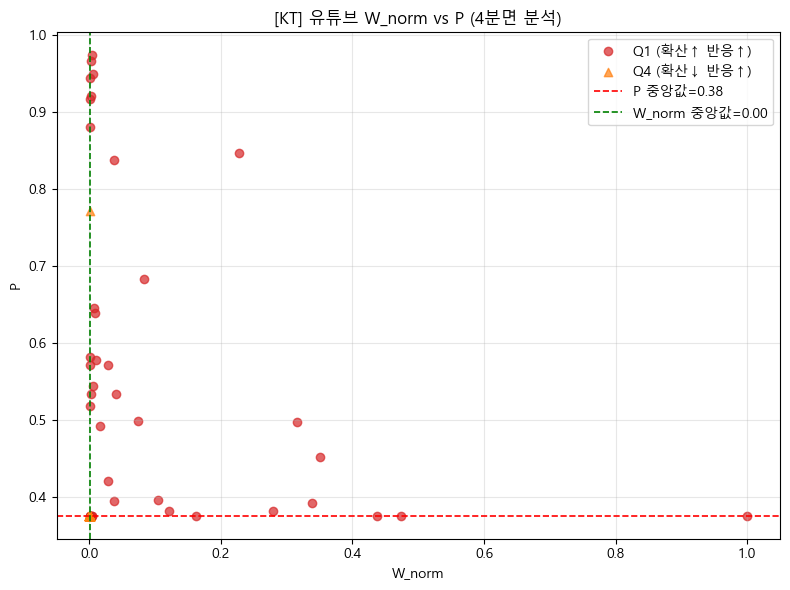


▶ [SKT] 4분면 분석 시작

=== [SKT] 유튜브 4분면 분포 (전체 119개) ===
            사분면  개수  비율(%)
0  Q1 (확산↑ 반응↑)  48  40.34
1  Q3 (확산↓ 반응↓)  47  39.50
2  Q2 (확산↑ 반응↓)  12  10.08
3  Q4 (확산↓ 반응↑)  12  10.08 



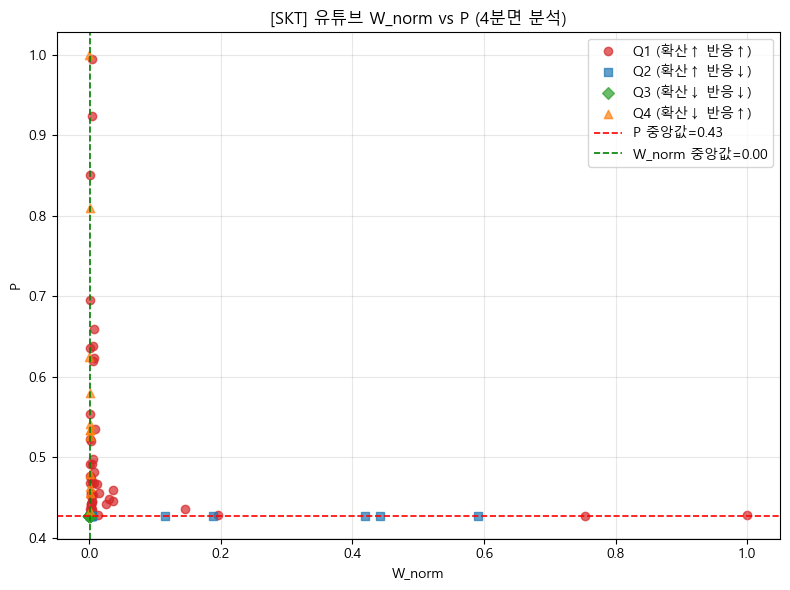


▶ [롯데] 4분면 분석 시작

=== [롯데] 유튜브 4분면 분포 (전체 84개) ===
            사분면  개수  비율(%)
0  Q1 (확산↑ 반응↑)  42   50.0
1  Q4 (확산↓ 반응↑)  42   50.0 



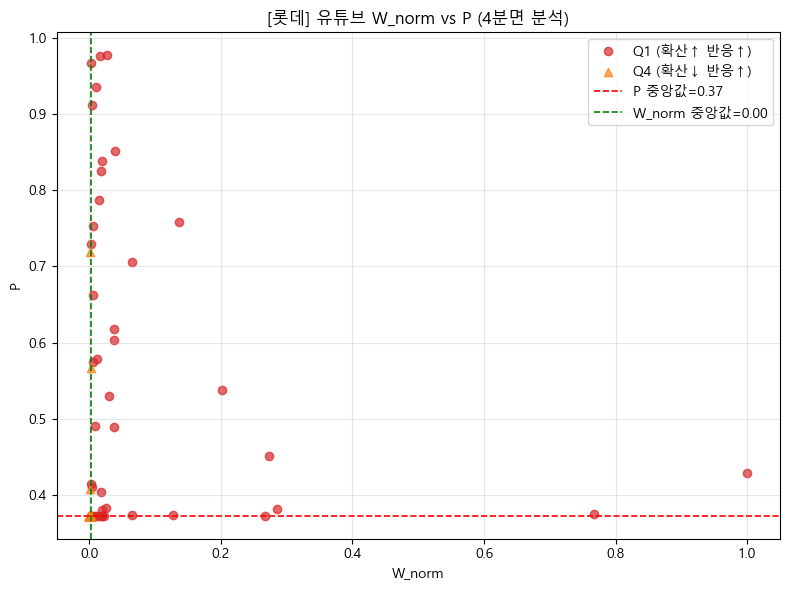

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 폰트 설정
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

# -------------------------------
# 1) 전체 df 로드
# -------------------------------
df = pd.read_excel(
    r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P.xlsx'
)

# 분석할 이슈 목록 자동 추출 (수동 지정도 가능)
issue_list = df['issue'].unique()


# -------------------------------
# 2) 이슈별로 4분면 분석 실행
# -------------------------------
for issue in issue_list:

    print(f"\n===============================")
    print(f"▶ [{issue}] 4분면 분석 시작")
    print(f"===============================")

    # ---- 이슈별 slice ----
    df_issue = df[df['issue'] == issue].copy()

    # ---- 유튜브 행만 사용 ----
    yt_rows = df_issue[df_issue['channel'] == '유튜브'][['P', 'W_norm']].copy()

    # 데이터 없는 경우 skip
    if yt_rows.empty:
        print(f"[{issue}] 유튜브 데이터 없음 → 건너뜀\n")
        continue

    # ---- 중앙값 계산 ----
    median_p = yt_rows['P'].median()
    median_w = yt_rows['W_norm'].median()

    # ---- 사분면 분류 ----
    def quadrant_info(row):
        if row['W_norm'] >= median_w and row['P'] >= median_p:
            return {'label': 'Q1 (확산↑ 반응↑)', 'color': '#D62728', 'marker': 'o'}
        elif row['W_norm'] >= median_w and row['P'] < median_p:
            return {'label': 'Q2 (확산↑ 반응↓)', 'color': '#1F77B4', 'marker': 's'}
        elif row['W_norm'] < median_w and row['P'] < median_p:
            return {'label': 'Q3 (확산↓ 반응↓)', 'color': '#2CA02C', 'marker': 'D'}
        else:
            return {'label': 'Q4 (확산↓ 반응↑)', 'color': '#FF7F0E', 'marker': '^'}

    quad_info = yt_rows.apply(quadrant_info, axis=1, result_type='expand')
    yt_rows = yt_rows.join(quad_info)

    # -------------------------------
    # 3) 사분면 개수 테이블 출력
    # -------------------------------
    quad_count = (
        yt_rows['label']
        .value_counts(dropna=False)
        .rename_axis('사분면')
        .reset_index(name='개수')
    )
    quad_count['비율(%)'] = (quad_count['개수'] / quad_count['개수'].sum() * 100).round(2)

    print(f"\n=== [{issue}] 유튜브 4분면 분포 (전체 {len(yt_rows)}개) ===")
    print(quad_count, "\n")

    # -------------------------------
    # 4) 산점도 시각화
    # -------------------------------
    plt.figure(figsize=(8, 6))

    for label, group in yt_rows.groupby('label'):
        plt.scatter(
            group['W_norm'], group['P'],
            label=label,
            color=group['color'].iloc[0],
            marker=group['marker'].iloc[0],
            alpha=0.7
        )

    # 중앙값 기준선
    plt.axhline(median_p, color='red', linestyle='--', linewidth=1.2, label=f'P 중앙값={median_p:.2f}')
    plt.axvline(median_w, color='green', linestyle='--', linewidth=1.2, label=f'W_norm 중앙값={median_w:.2f}')

    plt.xlabel("W_norm")
    plt.ylabel("P")
    plt.title(f"[{issue}] 유튜브 W_norm vs P (4분면 분석)")

    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [7]:
df.head()

,issue,datetime_3h,channel,viewCount,likeCount,comment_cnt,aligned_cnt_3h,aligned_cnt_6h,aligned_cnt_9h,match_sum,...,c_3_6,c_6_9,er_0_3,er_3_6,er_6_9,R,mu_R,std_R,P_z,P
0,GS,2024-12-26 12:00:00,blog,0,0,0,0,0,0,2,...,0,0,0.0,0.0,0.0,0.0,0.0,1.000000e-09,0.0,NaN
1,GS,2025-01-02 09:00:00,blog,0,0,0,0,0,0,6,...,0,0,0.0,0.0,0.0,0.0,0.0,1.000000e-09,0.0,NaN
2,GS,2025-01-03 06:00:00,blog,0,0,0,0,0,0,4,...,0,0,0.0,0.0,0.0,0.0,0.0,1.000000e-09,0.0,NaN
3,GS,2025-01-05 18:00:00,twitter,0,0,0,0,0,0,16,...,0,0,0.0,0.0,0.0,0.0,0.0,1.000000e-09,0.0,NaN
4,GS,2025-01-05 21:00:00,twitter,0,0,0,0,0,0,24,...,0,0,0.0,0.0,0.0,0.0,0.0,1.000000e-09,0.0,NaN


C:\Users\speec\AppData\Local\Temp\ipykernel_18780\3743217557.py:190: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\speec\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


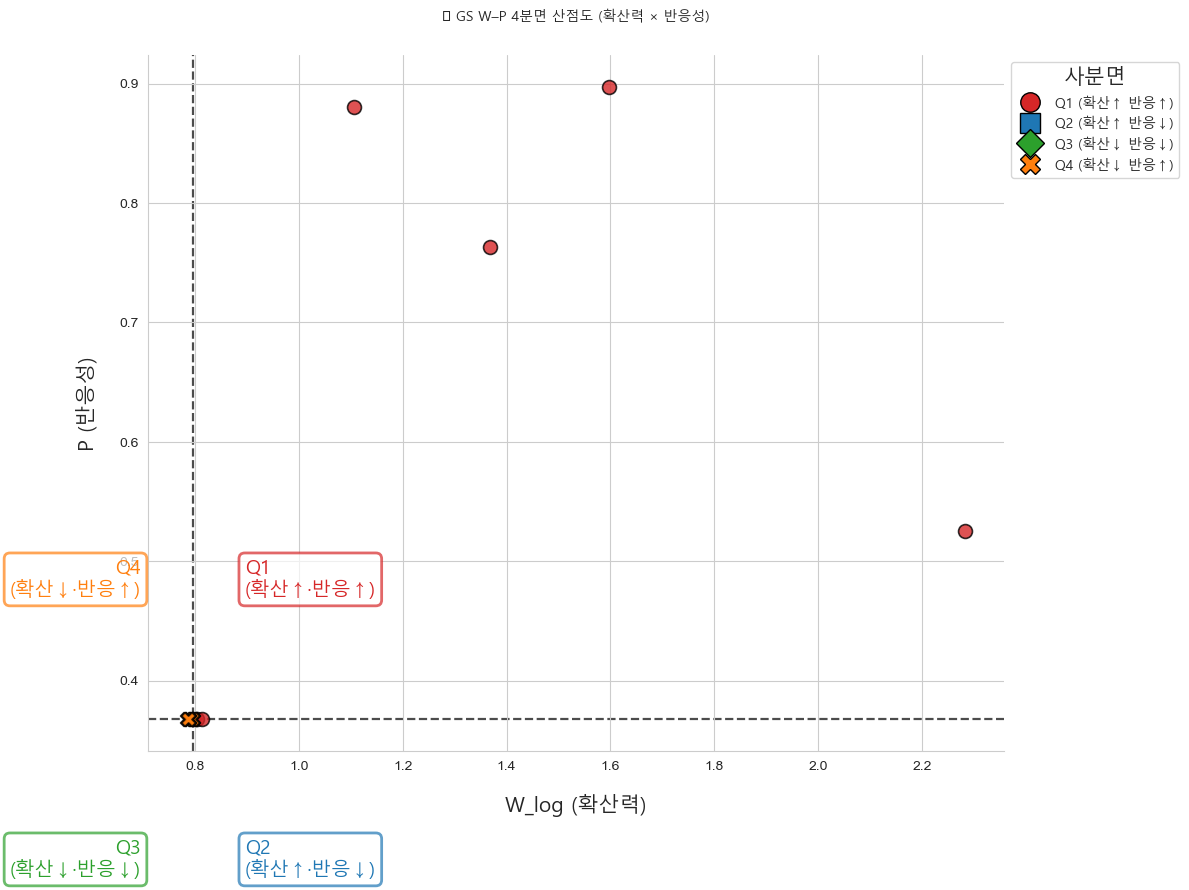

C:\Users\speec\AppData\Local\Temp\ipykernel_18780\3743217557.py:190: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\speec\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


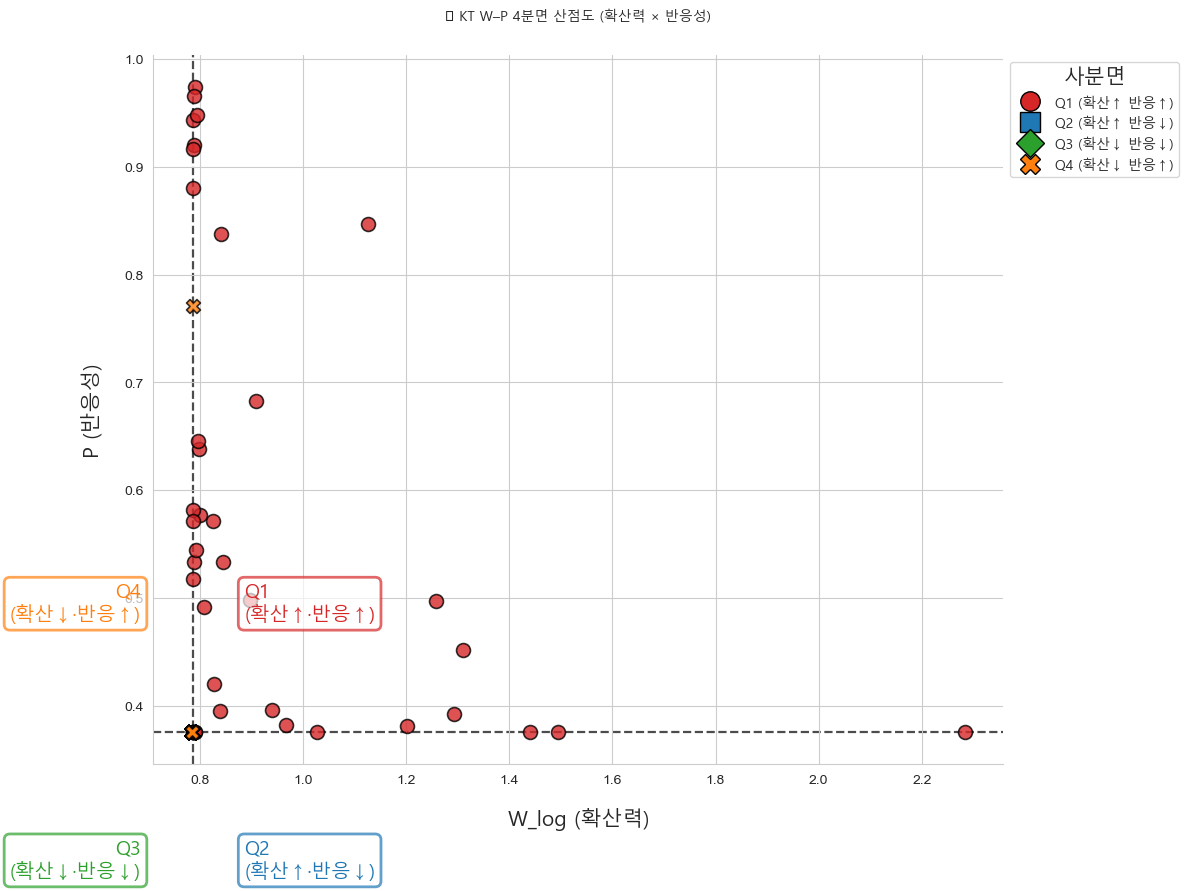

C:\Users\speec\AppData\Local\Temp\ipykernel_18780\3743217557.py:190: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\speec\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


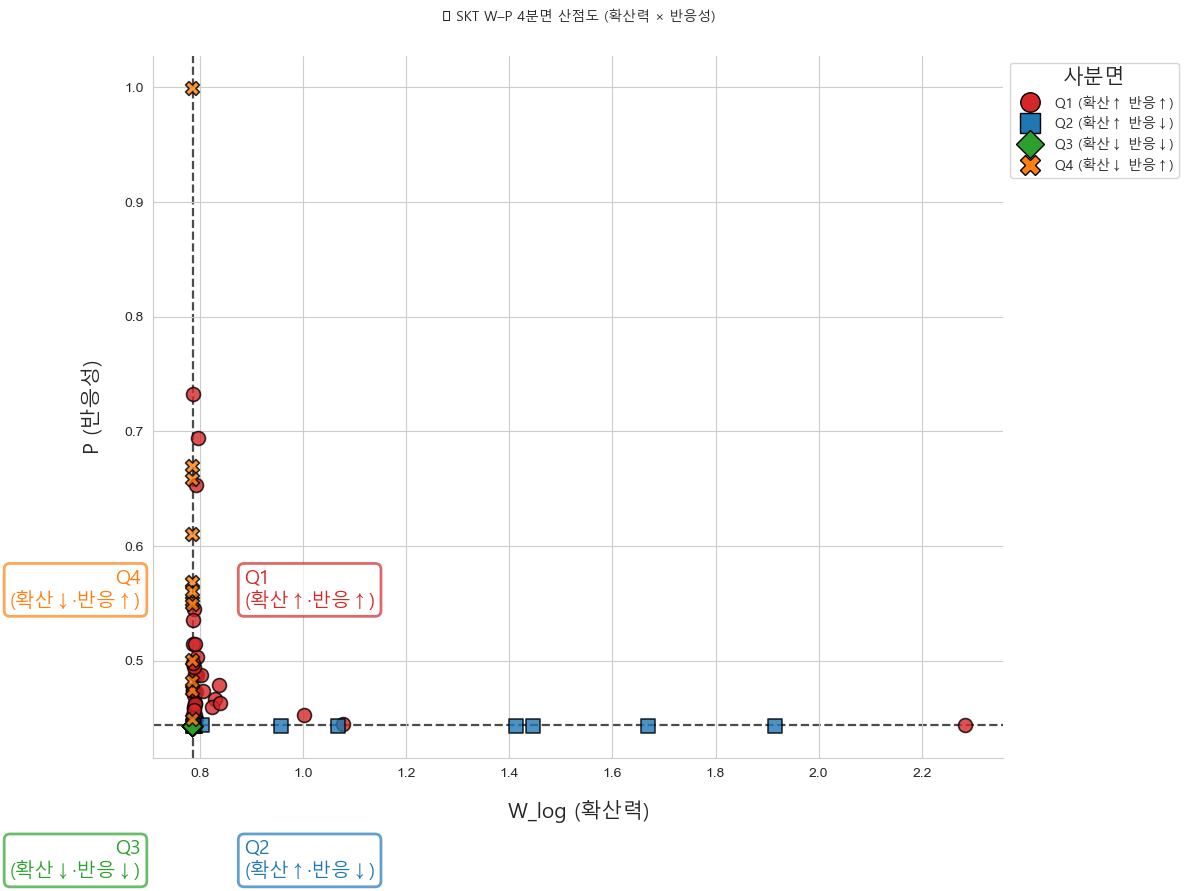

C:\Users\speec\AppData\Local\Temp\ipykernel_18780\3743217557.py:190: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\speec\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


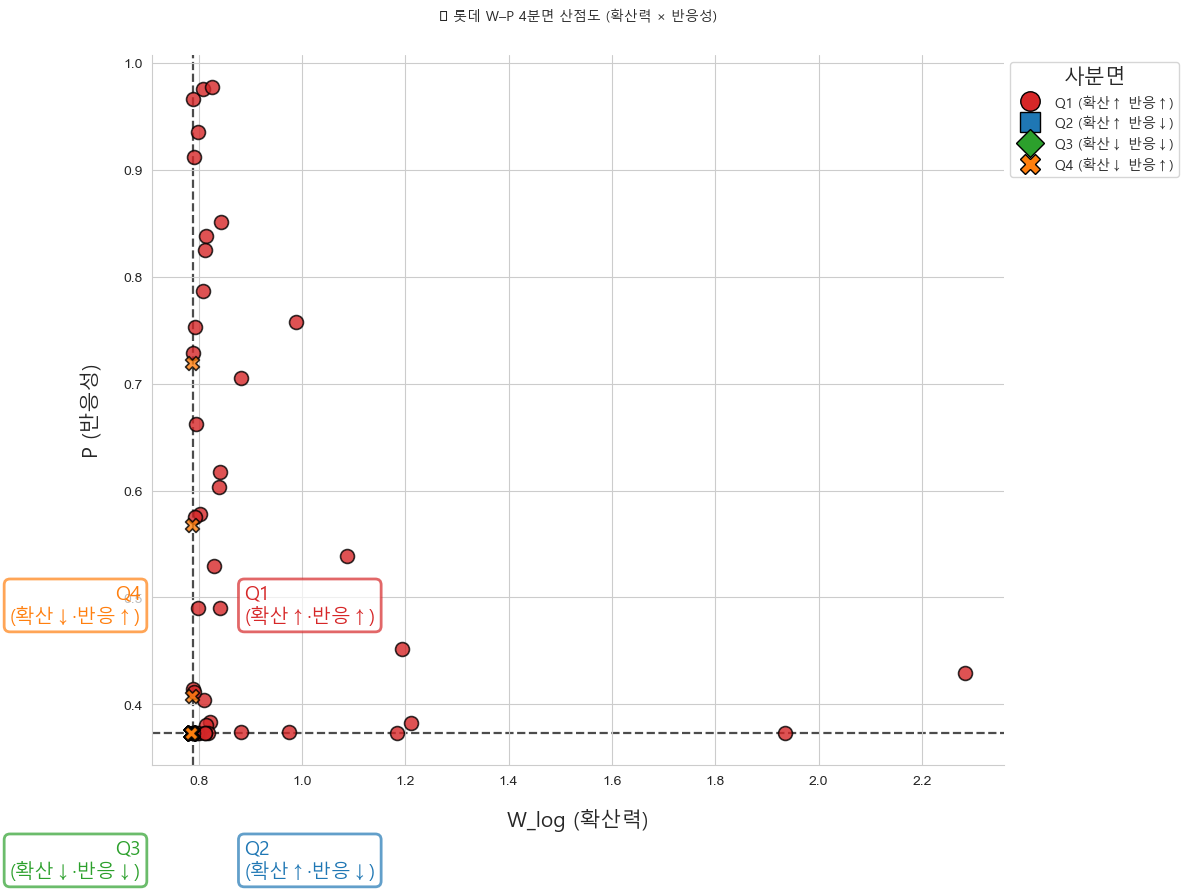

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import platform

# 이슈 리스트
issue_list = ['GS', 'KT', 'SKT', '롯데']

# 이슈별 엑셀 경로 사전
excel_paths = {
    issue: fr'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\P_output\{issue}_WP.xlsx'
    for issue in issue_list
}

# 한글 폰트 자동 지정
if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'
    font_path = "C:/Windows/Fonts/malgun.ttf"
elif platform.system() == 'Darwin':
    font_name = 'AppleGothic'
    font_path = "/System/Library/Fonts/AppleGothic.ttf"
else:  # Linux
    font_name = 'NanumGothic'
    font_path = None

mpl.rc('font', family=font_name)
mpl.rc('axes', unicode_minus=False)

# 폰트프로퍼티 지정
if font_path and os.path.exists(font_path):
    fontprop = fm.FontProperties(fname=font_path)
elif platform.system() != 'Windows' and platform.system() != 'Darwin':
    font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    nanum_font = [f for f in font_list if 'NanumGothic' in f]
    fontprop = fm.FontProperties(fname=nanum_font[0]) if nanum_font else None
else:
    fontprop = None

palette = {
    1: "#D62728",
    2: "#1F77B4",
    3: "#2CA02C",
    4: "#FF7F0E"
}
marker_shapes = {1: "o", 2: "s", 3: "D", 4: "X"}

for issue in issue_list:
    excel_path = excel_paths[issue]
    read_success = False
    try:
        try:
            sheets = pd.ExcelFile(excel_path).sheet_names
            if issue in sheets:
                df = pd.read_excel(excel_path, sheet_name=issue)
                read_success = True
            else:
                df = pd.read_excel(excel_path, sheet_name=0)
                read_success = True
        except Exception:
            df = pd.read_excel(excel_path)
            read_success = True

        if '이슈' in df.columns:
            if issue not in df['이슈'].unique():
                raise Exception(f'"{issue}" 이슈가 엑셀 컬럼 데이터 내에 없습니다.')
            df = df[df['이슈'] == issue]

        for col in ['W_log', 'P']:
            if col not in df.columns:
                raise Exception(f'"{issue}" 엑셀에서 필수 컬럼 "{col}" 없음. 파일 구조를 확인하세요.')
        df = df.dropna(subset=['W_log', 'P'])

        if df.empty:
            raise Exception(f'"{issue}" 이슈 데이터가 비어있습니다.')

    except Exception as e:
        print(f"[ERROR] {repr(e)}")
        print(f'엑셀 파일({excel_path}), 이슈 "{issue}"의 시트 및 컬럼 구조를 확인하세요.\n')
        continue

    # =============================
    # 1) W–P 4분면 기준 계산 (W_log 중앙값은 channel=="유튜브"일 때만 사용)
    # =============================

    # W_log은 유튜브만 활용하여 중앙값 구함
    if 'channel' in df.columns:
        wlog_youtube = df[df['channel'] == '유튜브']["W_log"]
        if wlog_youtube.empty:
            # 만약 유튜브 데이터가 없다면 전체 데이터로 fallback (경고 출력)
            print(f"[WARN] '{issue}' 이슈에서 channel이 '유튜브'인 데이터가 없어 전체 데이터로 W_log 중앙값 사용")
            W_median = df["W_log"].median()
        else:
            W_median = wlog_youtube.median()
    else:
        print(f"[WARN] '{issue}' 이슈에서 'channel' 컬럼이 없어 전체 데이터로 W_log 중앙값 사용")
        W_median = df["W_log"].median()
    P_median = df["P"].median()

    df["WP_quad"] = (
        df.apply(lambda x:
            1 if (x["W_log"] >= W_median and x["P"] >= P_median) else
            2 if (x["W_log"] >= W_median and x["P"] <  P_median) else
            3 if (x["W_log"] <  W_median and x["P"] <  P_median) else
            4
        , axis=1)
    )

    # =============================
    # 2) 4분면 산점도 - 시각화 업그레이드
    # =============================
    plt.figure(figsize=(12, 9))
    sns.set_style("whitegrid")
    ax = plt.gca()

    for quad in [1, 2, 3, 4]:
        tmp = df[df["WP_quad"] == quad]
        if not tmp.empty:
            plt.scatter(
                tmp["W_log"], tmp["P"],
                label=f"Q{quad}",
                c=palette[quad],
                s=100,
                marker=marker_shapes[quad],
                edgecolor='black',
                alpha=0.8,
                linewidth=1.2
            )

    plt.axvline(W_median, color="black", linestyle="--", linewidth=1.6, alpha=0.7, zorder=0)
    plt.axhline(P_median, color="black", linestyle="--", linewidth=1.6, alpha=0.7, zorder=0)

    # 사분면 레이블 추가
    q_labels = {
        1: ("Q1\n(확산↑·반응↑)", (W_median+0.1, P_median+0.1), 'left', 'bottom'),
        2: ("Q2\n(확산↑·반응↓)", (W_median+0.1, P_median-0.1), 'left', 'top'),
        3: ("Q3\n(확산↓·반응↓)", (W_median-0.1, P_median-0.1), 'right', 'top'),
        4: ("Q4\n(확산↓·반응↑)", (W_median-0.1, P_median+0.1), 'right', 'bottom'),
    }
    for k, (txt, (x, y), ha, va) in q_labels.items():
        plt.text(
            x, y, txt, fontsize=14, weight="bold",
            color=palette[k], bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7, ec=palette[k], lw=2),
            ha=ha, va=va,
            fontproperties=fontprop
        )

    # 타이틀/라벨 한글 깨짐 방지 - fontproperties 직접 할당
    plt.title(f"🌟 {issue} W–P 4분면 산점도 (확산력 × 반응성)", fontsize=20, weight='bold', pad=25, fontproperties=fontprop)
    plt.xlabel("W_log (확산력)", fontsize=15, weight='bold', labelpad=15, fontproperties=fontprop)
    plt.ylabel("P (반응성)", fontsize=15, weight='bold', labelpad=15, fontproperties=fontprop)

    # 범례(legend)에서 한글 깨짐 방지, 그리고 title_fontsize 경고 해결 (prop만!)
    legend_labels = [
        ("Q1 (확산↑ 반응↑)", palette[1]),
        ("Q2 (확산↑ 반응↓)", palette[2]),
        ("Q3 (확산↓ 반응↓)", palette[3]),
        ("Q4 (확산↓ 반응↑)", palette[4])
    ]
    handles = [plt.Line2D(
        [0], [0],
        marker=marker_shapes[i+1], color='w',
        markerfacecolor=c, markeredgecolor='black',
        markersize=14, linewidth=0, 
        label=label
    ) for i, (label, c) in enumerate(legend_labels)]

    # title_fontsize, title_fontproperties를 동시에 쓰면 에러 발생하므로, title_fontsize를 빼고 prop(fontproperties)만 사용
    leg = plt.legend(
        handles=handles,
        title='사분면',
        fontsize=13,
        # title_fontsize=15,  # 이 줄은 제거
        loc="upper left",
        bbox_to_anchor=(1,1),
        prop=fontprop,
        # title_fontproperties=fontprop  # 오직 prop= 만 사용 (fontproperties 내 포함)
    )
    # legend title 한글/크기 직접 패치 (matplotlib>=3.1에서 가능)
    if leg.get_title() is not None:
        leg.get_title().set_fontproperties(fontprop)
        leg.get_title().set_fontsize(15)
        leg.get_title().set_weight('bold')

    sns.despine(left=False, bottom=False)

    plt.tight_layout()
    plt.show()
